# Bayesian Analysis on Digital Asset Data

### Background

Digital asset markets operate 24/7.<br/>
For a given asset e.g., BTC, ETH, multiple markes/pairs may exist.
The most actively traded ones ar spot and perptual markets.
- In spot markets, the actual asset is traded directly
- In perpetual markets, derivatives of the asset are traded.
  
Although the price in these markets are correlated, they are oten not identical.

---

**Bid and Ask** <br/>
There are twwo types of prices:
- The **bid** price represents the price that a buyer is willing to pay for an asset
- The **ask** price is the price that a seller is willing to accept
- The **best bid** is the highest among all bid offers in the market
- The **best ask** is the lowest among all ask offers

---
**Reaction Time**

On Binance, the reaction tim between these two markets is typically around 3-5 milliseconds (ms). A sudden price movement in one market is usually rflected in the other within 3-5 ms. However, not every price movement is reliable - some revert to their original level before affecting the other market.

### Objectives
#### Primary Objective: Generate signals for 
- i) spot trading by considering price movements in perpetual prices
- ii) perpetual trading by considering price movements in spot prices. You need to predict the price that will be reached in one market within 5 ms, based on sudden price changes observed in the other one. 

#### Secondary Objectives: 
- Identify whether the spot or perpetual market more often leads price discovery. Which 
one drives the other one most? 
- Detect and characterize noise events—sudden price changes that do not affect the other 
market. 
- Estimate the momentum quality of the sudden price changes. You are encouraged to 
explore how long a price movement sustains its momentum—either in terms of time 
duration or price delta.  For example, in the chart below, the movement in the red 
region shows high initial momentum but fades quickly, whereas the movement in the 
blue region, despite having lower intensity, persists over a longer period. 

#### Dataset

The data used is TRB/USDT pair

In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [2]:
pio.renderers.default="notebook"

In [3]:
df_spot = pd.read_csv('./data/trb_usdt_futures_export.csv')
df_spot_trade = pd.read_csv('./data/trb_usdt_trades_export.csv')
df_perpetual = pd.read_csv('./data/trb_usdt_spot_export.csv')

In [4]:
df_spot['time'] = pd.to_datetime(df_spot['time'], format='mixed', errors='coerce')
df_spot_trade['time'] = pd.to_datetime(df_spot_trade['time'], format='mixed', errors='coerce')
df_perpetual['time'] = pd.to_datetime(df_perpetual['time'], format='mixed', errors='coerce')

In [5]:
print(df_spot['time'].isna().sum())
print(df_spot_trade['time'].isna().sum())
print(df_perpetual['time'].isna().sum())

0
0
0


In [6]:
df_spot.info(), df_spot_trade.info(), df_perpetual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5593820 entries, 0 to 5593819
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   time       datetime64[ns, UTC]
 1   symbol     object             
 2   bid_price  float64            
 3   ask_price  float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 170.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291966 entries, 0 to 291965
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   time             291966 non-null  datetime64[ns, UTC]
 1   symbol           291966 non-null  object             
 2   price            291966 non-null  float64            
 3   quantity         291966 non-null  float64            
 4   is_market_maker  291966 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 11.

(None, None, None)

### Add Timedelta in MS

In [7]:
df_spot = df_spot.sort_values('time').reset_index(drop=True)
df_spot_trade=df_spot_trade.sort_values('time').reset_index(drop=True)
df_perpetual=df_perpetual.sort_values('time').reset_index(drop=True)

In [8]:
df_spot['mid_price'] = (df_spot['bid_price']+df_spot['ask_price'])/2
df_perpetual['mid_price'] = (df_perpetual['bid_price']+df_perpetual['ask_price'])/2

### Merge Spot and Spot Trade Data

In [9]:
df_spot_merged = pd.merge_asof(
    df_spot_trade,
    df_spot[['time', 'bid_price', 'ask_price', 'mid_price']],
    on='time',
    direction='backward'
)

In [10]:
df_spot_merged.head()

,time,symbol,price,quantity,is_market_maker,bid_price,ask_price,mid_price
0,2025-05-27 12:00:00.382000+00:00,TRB_USDT,43.16,6.750,t,43.138,43.141,43.1395
1,2025-05-27 12:00:00.523000+00:00,TRB_USDT,43.15,7.950,t,43.138,43.141,43.1395
2,2025-05-27 12:00:01.824000+00:00,TRB_USDT,43.17,0.199,t,43.138,43.141,43.1395
3,2025-05-27 12:00:02.490000+00:00,TRB_USDT,43.16,1.010,t,43.127,43.137,43.1320
4,2025-05-27 12:00:04.225000+00:00,TRB_USDT,43.15,4.678,t,43.117,43.119,43.1180


In [11]:
df_spot_merged.shape, df_spot.shape

((291966, 8), (5593820, 5))

### Add Features in Spot Merged Data

In [12]:
df_spot_merged['price_dev'] = df_spot_merged['price'] - df_spot_merged['mid_price']
df_spot_merged['trade_direction'] = np.where(df_spot_merged['price'] > df_spot_merged['mid_price'], 1,-1)
df_spot_merged['signed_volume'] = df_spot_merged['trade_direction'] * df_spot_merged['quantity']
df_spot_merged['timedelta_ms'] = df_spot_merged['time'].diff().dt.total_seconds() * 1000

In [13]:
df_spot_merged.set_index('time', inplace=True)

### Add Rolling Window Features and Percentage Change of Each Window

In [14]:
df_spot_merged['rolling_signed_volume_3ms'] = df_spot_merged['signed_volume'].rolling('3ms').sum().fillna(0)
df_spot_merged['rolling_signed_volume_5ms'] = df_spot_merged['signed_volume'].rolling('5ms').sum().fillna(0)
df_spot_merged['window_3'] = df_spot_merged['mid_price'].rolling('3ms').mean()
df_spot_merged['window_5'] = df_spot_merged['mid_price'].rolling('5ms').mean()
df_spot_merged['window_3_pct_change'] = df_spot_merged['window_3'].pct_change() * 100
df_spot_merged['window_5_pct_change'] = df_spot_merged['window_5'].pct_change() * 100

## Spot Data

In [15]:
df_spot_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
price,291966.0,50.414154,2.806320,43.060000,48.990000,50.6800,52.220000,56.870000
quantity,291966.0,2.360075,7.934132,0.001000,0.198000,0.6480,3.249750,2065.834000
bid_price,291966.0,50.387088,2.805252,43.019000,48.979000,50.6590,52.198000,56.817000
ask_price,291966.0,50.404853,2.807347,43.020000,48.999000,50.6730,52.215000,56.851000
mid_price,291966.0,50.395971,2.806200,43.019500,48.989000,50.6655,52.205000,56.828500
price_dev,291966.0,0.018183,0.058428,-1.786500,0.006000,0.0195,0.033000,1.046500
trade_direction,291966.0,0.648541,0.761181,-1.000000,1.000000,1.0000,1.000000,1.000000
signed_volume,291966.0,1.372575,8.163116,-2065.834000,0.147000,0.2370,2.000000,1329.076000
timedelta_ms,291965.0,293.624219,747.514726,0.000000,0.000000,13.0000,206.000000,22188.000000
rolling_signed_volume_3ms,291966.0,1.774713,34.573173,-2104.486000,0.154000,0.5790,4.043000,1334.812000


In [16]:
df_spot_merged.head()

,symbol,price,quantity,is_market_maker,bid_price,ask_price,mid_price,price_dev,trade_direction,signed_volume,timedelta_ms,rolling_signed_volume_3ms,rolling_signed_volume_5ms,window_3,window_5,window_3_pct_change,window_5_pct_change
time,,,,,,,,,,,,,,,,,
2025-05-27 12:00:00.382000+00:00,TRB_USDT,43.16,6.750,t,43.138,43.141,43.1395,0.0205,1,6.750,NaN,6.750,6.750,43.1395,43.1395,NaN,NaN
2025-05-27 12:00:00.523000+00:00,TRB_USDT,43.15,7.950,t,43.138,43.141,43.1395,0.0105,1,7.950,141.0,7.950,7.950,43.1395,43.1395,0.000000,0.000000
2025-05-27 12:00:01.824000+00:00,TRB_USDT,43.17,0.199,t,43.138,43.141,43.1395,0.0305,1,0.199,1301.0,0.199,0.199,43.1395,43.1395,0.000000,0.000000
2025-05-27 12:00:02.490000+00:00,TRB_USDT,43.16,1.010,t,43.127,43.137,43.1320,0.0280,1,1.010,666.0,1.010,1.010,43.1320,43.1320,-0.017385,-0.017385
2025-05-27 12:00:04.225000+00:00,TRB_USDT,43.15,4.678,t,43.117,43.119,43.1180,0.0320,1,4.678,1735.0,4.678,4.678,43.1180,43.1180,-0.032458,-0.032458


In [17]:
df_spot_merged = df_spot_merged.reset_index()

In [18]:
df_spot_merged.head()

,time,symbol,price,quantity,is_market_maker,bid_price,ask_price,mid_price,price_dev,trade_direction,signed_volume,timedelta_ms,rolling_signed_volume_3ms,rolling_signed_volume_5ms,window_3,window_5,window_3_pct_change,window_5_pct_change
0,2025-05-27 12:00:00.382000+00:00,TRB_USDT,43.16,6.750,t,43.138,43.141,43.1395,0.0205,1,6.750,NaN,6.750,6.750,43.1395,43.1395,NaN,NaN
1,2025-05-27 12:00:00.523000+00:00,TRB_USDT,43.15,7.950,t,43.138,43.141,43.1395,0.0105,1,7.950,141.0,7.950,7.950,43.1395,43.1395,0.000000,0.000000
2,2025-05-27 12:00:01.824000+00:00,TRB_USDT,43.17,0.199,t,43.138,43.141,43.1395,0.0305,1,0.199,1301.0,0.199,0.199,43.1395,43.1395,0.000000,0.000000
3,2025-05-27 12:00:02.490000+00:00,TRB_USDT,43.16,1.010,t,43.127,43.137,43.1320,0.0280,1,1.010,666.0,1.010,1.010,43.1320,43.1320,-0.017385,-0.017385
4,2025-05-27 12:00:04.225000+00:00,TRB_USDT,43.15,4.678,t,43.117,43.119,43.1180,0.0320,1,4.678,1735.0,4.678,4.678,43.1180,43.1180,-0.032458,-0.032458


### Linear Model

The objective of this model is to determine the **Sudden Price Changes** on Each Market (Spot and Perpetual)

In [19]:
features = [
    'timedelta_ms',
    'mid_price',
    'price_dev',
    'rolling_signed_volume_3ms',
    'rolling_signed_volume_5ms'
]
target = 'window_3_pct_change'

In [20]:
df_model = df_spot_merged[features + [target]].dropna().reset_index(drop=True)

In [21]:
df_sample = df_model.sample(30000, random_state=42)
df_sample.head()

,timedelta_ms,mid_price,price_dev,rolling_signed_volume_3ms,rolling_signed_volume_5ms,window_3_pct_change
218578,382.0,51.5490,0.0210,0.346,0.346,0.047550
107234,0.0,54.2840,0.0260,0.722,0.722,0.000000
107192,0.0,54.2075,0.0325,5.718,5.994,0.000000
119961,1.0,51.8050,0.0250,5.800,5.800,0.010942
109195,54.0,54.1560,0.0340,0.300,0.300,0.011080


In [22]:
X_data = df_sample[features].values
y_data = df_sample[target].values

In [23]:
with pm.Model() as model_3ms:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_obs = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_3ms = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_3ms.extend(pm.sample_posterior_predictive(idata_3ms))

Initializing NUTS using jitter+adapt_diag...
INFO	pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
/home/lucky/anaconda3/envs/python311/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning:

PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library

Multiprocess sampling (4 chains in 4 jobs)
INFO	pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]
INFO	pymc.s

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
INFO	pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

### Visual Representation of Linear 3ms Model

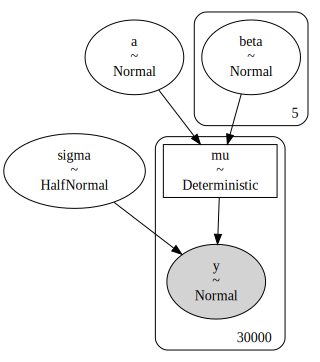

In [24]:
pm.model_to_graphviz(model_3ms)

### Posterior Check

In [25]:
idata_3ms.posterior

<xarray.Dataset> Size: 960MB
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 5, mu_dim_0: 30000)
Coordinates:
  * chain       (chain) int64 32B 0 1 2 3
  * draw        (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 40B 0 1 2 3 4
  * mu_dim_0    (mu_dim_0) int64 240kB 0 1 2 3 4 ... 29996 29997 29998 29999
Data variables:
    a           (chain, draw) float64 32kB 0.004774 0.006912 ... -0.0009993
    beta        (chain, draw, beta_dim_0) float64 160kB -9.031e-08 ... 4.703e-05
    sigma       (chain, draw) float64 32kB 0.02867 0.02836 ... 0.02845 0.0285
    mu          (chain, draw, mu_dim_0) float64 960MB -4.273e-05 ... -0.0008732
Attributes:
    created_at:                 2025-06-30T00:01:02.914275+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.23.0
    sampling_time:              53.20850849151611
    tuning_steps:               1000

[]

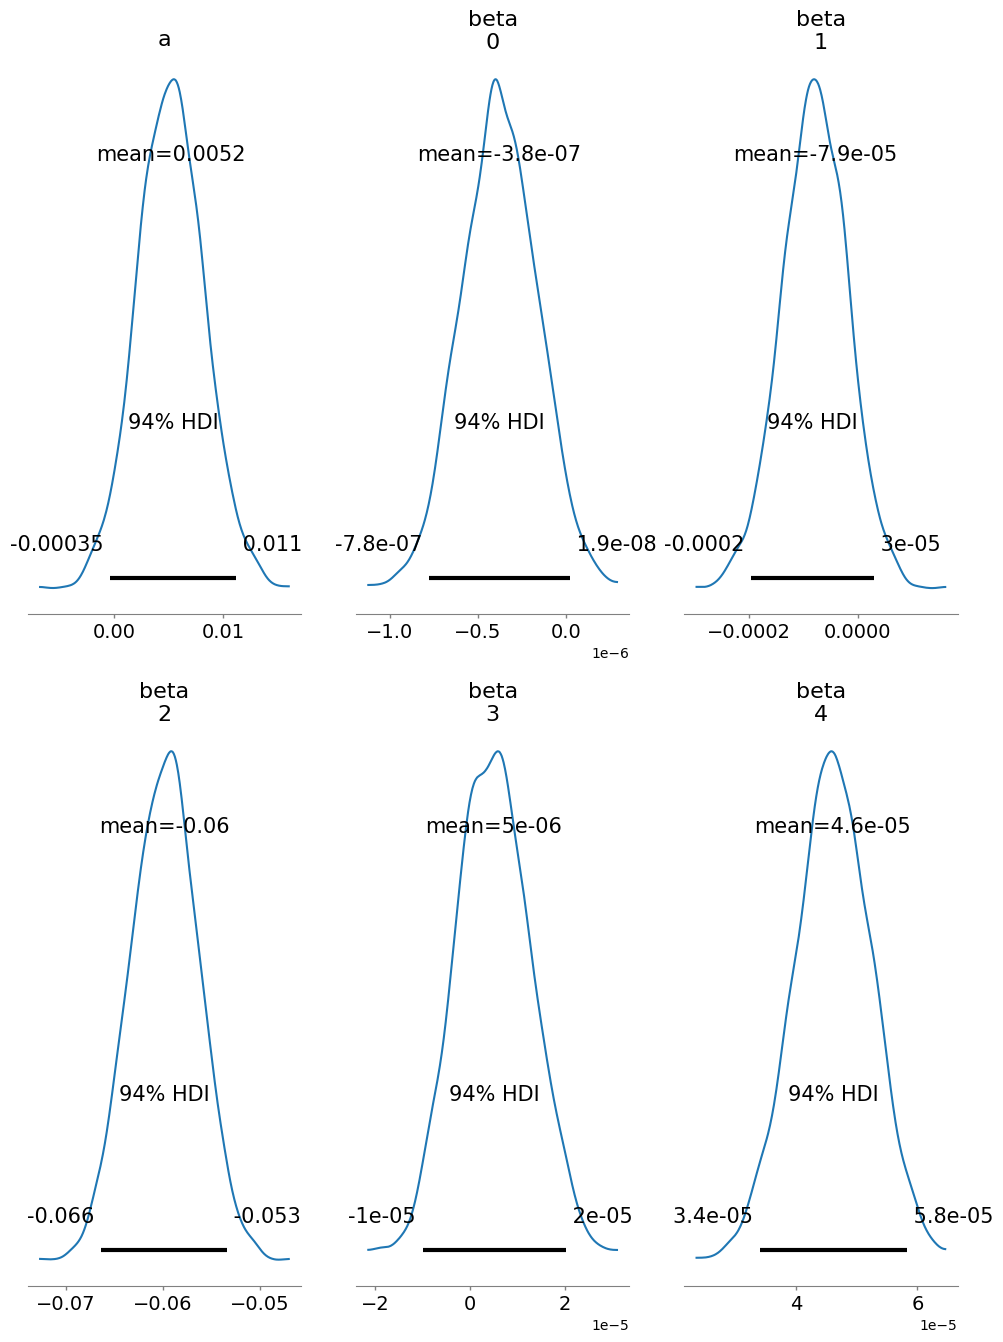

In [27]:
az.plot_posterior(idata_3ms, var_names=['~posterior_mean','~mu','~sigma'], figsize=(12,16))
plt.plot()

[]

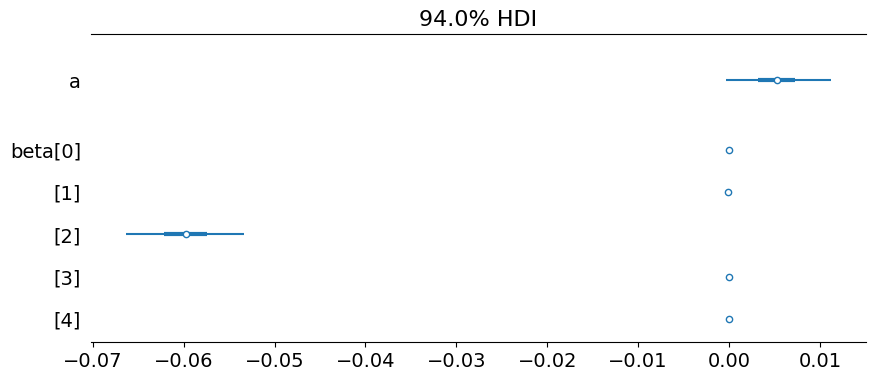

In [28]:
az.plot_forest(idata_3ms, var_names=['a', 'beta'], combined=True, figsize=(10,4))
plt.plot()

In [57]:
az.summary(idata_3ms, var_names=['a', 'beta', 'sigma','posterior_mean'], round_to=5, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a,0.00523,0.00305,-0.00035,0.01117
beta[0],-0.00000,0.00000,-0.00000,0.00000
beta[1],-0.00008,0.00006,-0.00020,0.00003
beta[2],-0.05980,0.00347,-0.06633,-0.05338
beta[3],0.00000,0.00001,-0.00001,0.00002
beta[4],0.00005,0.00001,0.00003,0.00006
sigma,0.02855,0.00012,0.02834,0.02878
posterior_mean,0.00016,0.00016,-0.00014,0.00047


- According to the statistics summary of the posterior distribution, the beta[2] (price_dev) has a meaningful negative relationship with the percentage price change (5ms window)
- In contrast, the oither features (beta[0], beta[1], beta[3], and beta[4]) are not good predictors. Their posterior credible intervals contain zero, which indicates that their relationship with the percentage price change is either non-existent or too small
- The standard deviation is in the range of [2.83%, 2.88%], hence the claim that the price typically moves by as much as +- 0.007% is not supported by the model's estimate of the typical price movement, which is around 2.8%

In [53]:
mu_mean = idata_3ms.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]
idata_3ms.posterior['posterior_mean'] = mu_mean

spot_population_mean_3pct_change = np.mean(df_spot_merged['window_3_pct_change']) * 100
print(f"Mean percentage change of spot population: {spot_population_mean_3pct_change:.8f}%")

Mean percentage change of spot population: 0.00580142%


[]

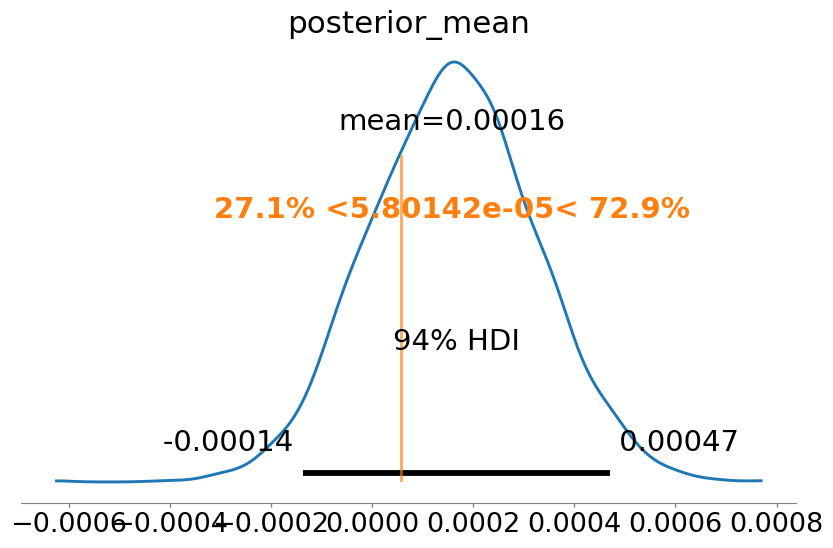

In [49]:
az.plot_posterior(idata_3ms, var_names=['posterior_mean'], figsize=(10,6), ref_val=0.0000580142)
plt.plot()

- The curve above shows that the mean percentage change within a 3 ms window is approximately 0.016%, with 94% probability that the true mean lies between -0.014% and 0.047%.
- The lower bound of the 94% highest density interval (HDI) is negative, suggesting the possibility of a slight decrease in price, while the upper bound indicates a potential slight increase.
- The population mean of the spot percentage change (in 3ms window) is 0.0058%, which falls within the 94% HDI and is very close to the posterior mean, supporting the model's validity.

In [30]:
features = [
    'timedelta_ms',
    'mid_price',
    'price_dev',
    'rolling_signed_volume_3ms',
    'rolling_signed_volume_5ms'
]
target = 'window_5_pct_change'

df_model = df_spot_merged[features + [target]].dropna().reset_index(drop=True)
df_sample = df_model.sample(30000, random_state=42)

X_data = df_sample[features].values
y_data = df_sample[target].values

with pm.Model() as model_5ms:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_obs = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_5ms = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_5ms.extend(pm.sample_posterior_predictive(idata_5ms))

Initializing NUTS using jitter+adapt_diag...
INFO	pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO	pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]
INFO	pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [a, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
INFO	pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

### Visual Representation of 5ms Linear Model

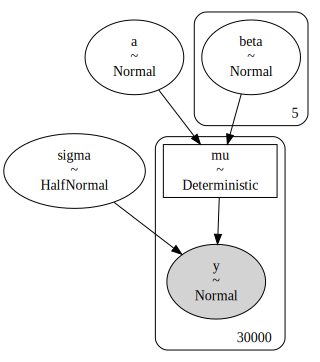

In [31]:
pm.model_to_graphviz(model_5ms)

[]

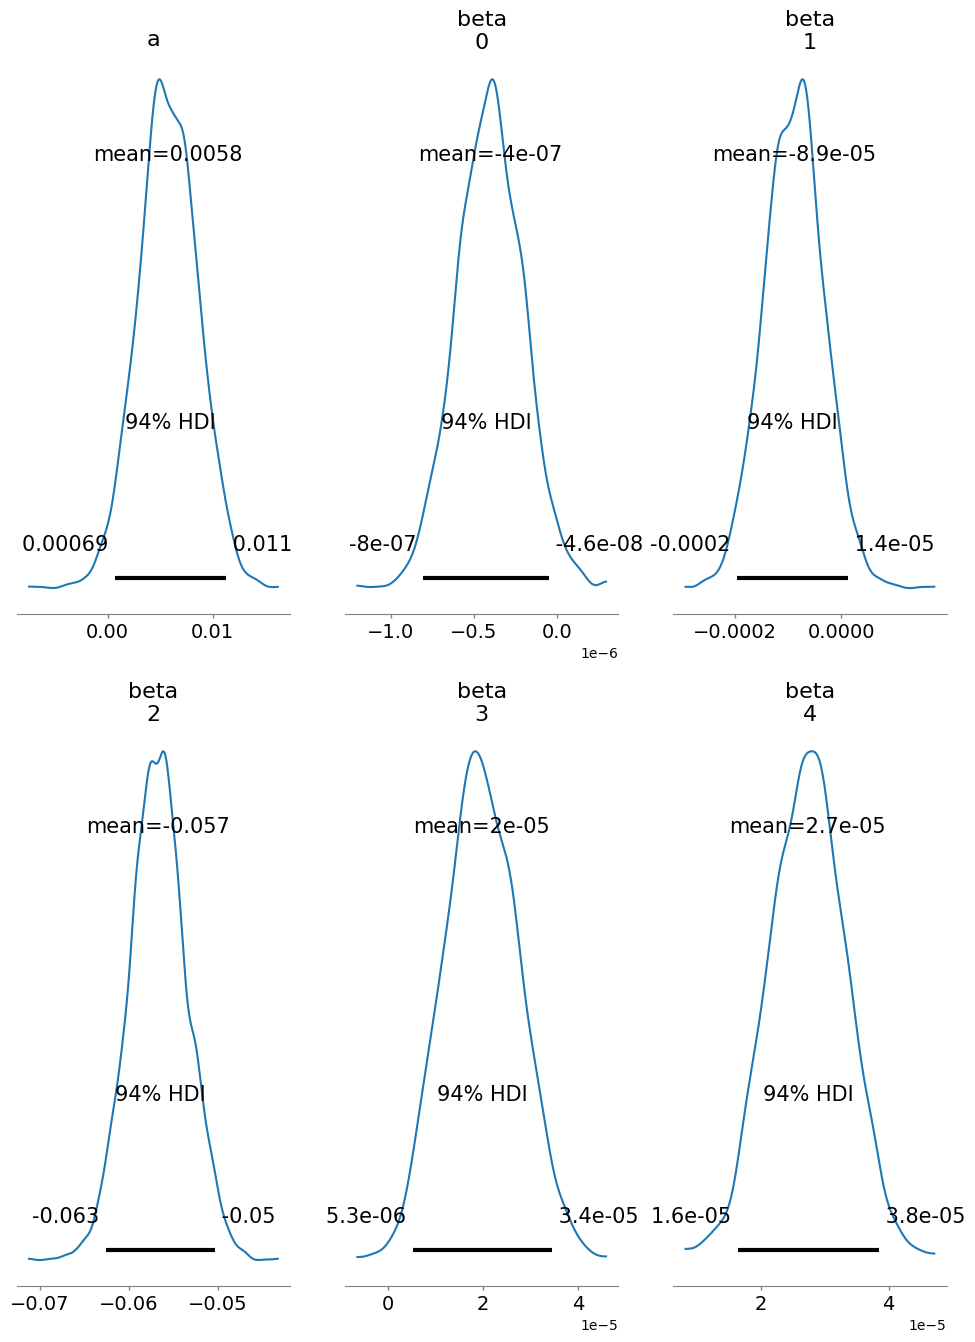

In [43]:
az.plot_posterior(idata_5ms, var_names=['~posterior_mean','~mu','~sigma'], figsize=(12,16))
plt.plot()

[]

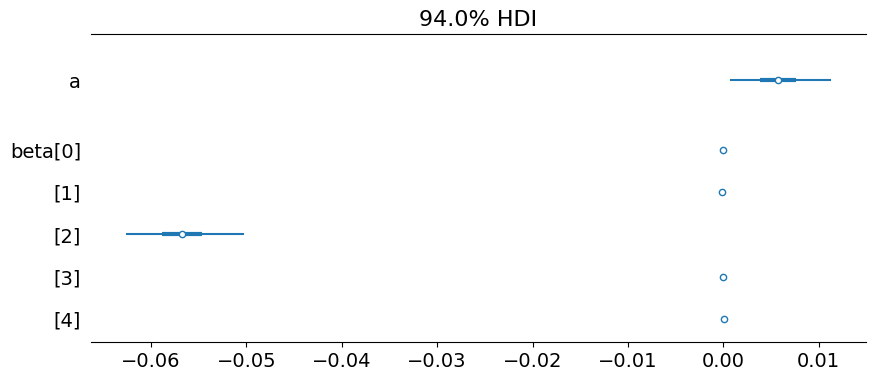

In [34]:
az.plot_forest(idata_5ms, var_names=['a', 'beta'], combined=True, figsize=(10,4))
plt.plot()

In [55]:
az.summary(idata_5ms, var_names=['a', 'beta', 'sigma','posterior_mean'], round_to=5, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a,0.00575,0.00285,0.00069,0.01125
beta[0],-0.00000,0.00000,-0.00000,-0.00000
beta[1],-0.00009,0.00006,-0.00020,0.00001
beta[2],-0.05669,0.00328,-0.06261,-0.05030
beta[3],0.00002,0.00001,0.00001,0.00003
beta[4],0.00003,0.00001,0.00002,0.00004
sigma,0.02706,0.00011,0.02684,0.02727
posterior_mean,0.00022,0.00016,-0.00008,0.00050


- According to the statistics summary of the posterior distribution, the beta[2] (price_dev) has a meaningful negative relationship with the percentage price change (5ms window)
- In contrast, the oither features (beta[0], beta[1], beta[3], and beta[4]) are not good predictors. Their posterior credible intervals contain zero, which indicates that their relationship with the percentage price change is either non-existent or too small
- The standard deviation is in the range of [2.68%, 2.73%], hence the claim that the price typically moves by as much as +- 0.007% is not supported by the model's estimate of the typical price movement, which is around 2.7%

In [58]:
mu_mean = idata_5ms.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]
idata_5ms.posterior['posterior_mean'] = mu_mean

spot_population_mean_5pct_change = np.mean(df_spot_merged['window_5_pct_change']) * 100
print(f"Mean percentage change of spot population: {spot_population_mean_5pct_change:.8f}%")

Mean percentage change of spot population: 0.00576667%


[]

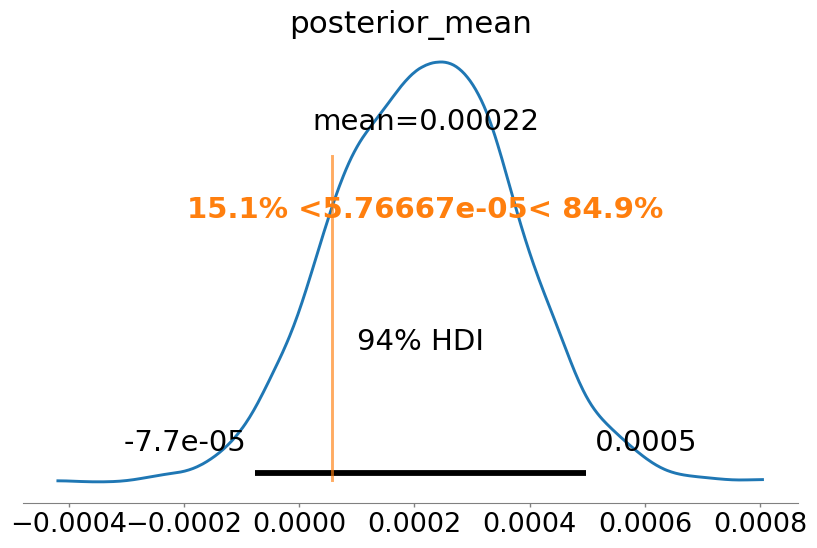

In [59]:
az.plot_posterior(idata_5ms, var_names=['posterior_mean'], figsize=(10,6), ref_val=0.0000576667)
plt.plot()

The posterior mean of percentage change in the spot market over a 5 ms window is approximately 0.022%, with a 94% probability that the true mean lies between −0.008% and +0.05%. <br/>

From the curve, we observe that the posterior mean of the percentage change in the 5 ms window is higher than that in the 3 ms window. Additionally, it shows **lower uncertainty**, as reflected by a narrower 94% HDI compared to the 3 ms window. <br/>
So for this exercise, I will choose the 5 ms window percentage change as a working definition of **sudden price change** in the **Spot Market**.<br/>


**A sudden price change in the spot market is defined as any 5 ms window percentage change that falls outside the 94% HDI range**: 
- less than −0.008% or 
- greater than +0.05%.